# **Trabalho 3**

A partir do material visto nas aulas, utilizar técnicas de aprendizado de
máquina para criar algoritmos de alocação ou trading sistemático.
- Devem ser apresentadas duas estratégias, baseadas em técnicas de
aprendizado de máquina diferentes (Redes Neurais MLP, Árvores de Decisão
ou outras técnicas não vistas na aula).
- Os algoritmos desenvolvidos devem utilzar conjuntos dados de entrada e
saída diferentes daqueles usados nas aulas.
No caso da alocação sistemática, outras classes de ativos devem ser
utilizados ou adicionadas às entradas e saídas dos algoritmos.
No caso do trading sistemático, outros indicadores devem ser utilizados ou
adicionadas às entradas dos algoritmos.
- Apresentar os resultados de ambos os conjuntos de dados de treinamento e
validação.

## **Grupo:**

* Amanda Caroline de Oliveira Pires - 12559090
* Emanuel Victor da Silva Favorato - 12558151
* Rafael Zimmer - 12542612



## Alocação Sistemática

In [221]:
import requests
import os

import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

seaborn.set(style='whitegrid')

In [222]:
def get_adjusted(symbol):
    if os.path.exists(f"{symbol}_close.csv"):
        try:
            security = pandas.read_csv(f"{symbol}_close.csv", index_col=0, parse_dates=True)
            security.index = pandas.to_datetime(security.index)
            return security
        except pandas.errors.EmptyDataError:
            pass
    if not symbol or symbol == "":
        raise ValueError("Invalid symbol: ", symbol)
    try:
        url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey=U93DVTNCTOO1DTTI"
        response = requests.get(url)

        data = pandas.DataFrame(response.json())
    except ValueError:
        print("Possible retry with: ", symbol)
        return get_adjusted(symbol)
    formatted_data = data[data.keys()[1]][5:]
    adjusted = pandas.DataFrame.from_records(formatted_data.values)["5. adjusted close"]
    security = pandas.DataFrame(adjusted.values.astype(float), columns=["value"],
                                index=formatted_data.index).sort_index()
    security.index.name = "Date"
    security.to_csv(f"{symbol}_close.csv")
    return get_adjusted(symbol)


def changes(security: pandas.DataFrame):
    return security.values / security.values[0]

<AxesSubplot:xlabel='Date'>

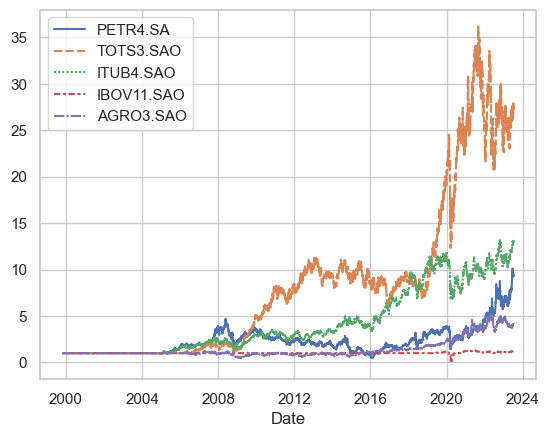

In [223]:
def create_portfolio(symbols=None):
    if not symbols:
        symbols = ["AAPL", "GOOGL", "IBM", "VOO"]
    portfolio = {
        symbol: get_adjusted(symbol) for symbol in symbols
    }

    portfolio_df = pandas.concat(portfolio, axis=1).fillna(method="bfill")
    changes_df = portfolio_df.apply(changes)

    return portfolio_df, changes_df

# https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords=IBOV&apikey=$key
portfolio_df, changes_df = create_portfolio(
    symbols=["IBM", "SPY", "USD", "PETR4.SA", "TOTS3.SAO", "ITUB4.SAO", "IBOV11.SAO", "AGRO3.SAO"])

sample = changes_df[["PETR4.SA", "TOTS3.SAO", "ITUB4.SAO", "IBOV11.SAO", "AGRO3.SAO"]]

seaborn.lineplot(sample)

In [224]:
def momentum(security, T):
    momentum_T = security.copy()
    momentum_T[0:T] = 0

    for i in range(T, len(momentum_T.values)):
        momentum_T.iloc[i] = security.iloc[i] / security.iloc[i - T]

    return momentum_T


def price_size(security, T):
    pcs = security / security.rolling(T).sum()

    return pcs.fillna(method='bfill')

def vol_rolling(security, T):
    vol = security.pct_change().rolling(T).std(ddof=0)

    return vol.fillna(method='bfill')

petr4 = portfolio_df["PETR4.SA"]

momentum_1T = momentum(petr4, 30)
momentum_3T = momentum(petr4, 90)
momentum_6T = momentum(petr4, 180)

pcs_1T, pcs_6T, vol_1T, vol_6T = [
    price_size(petr4, 30), price_size(petr4, 180),
    vol_rolling(petr4, 30), vol_rolling(petr4, 180)
]

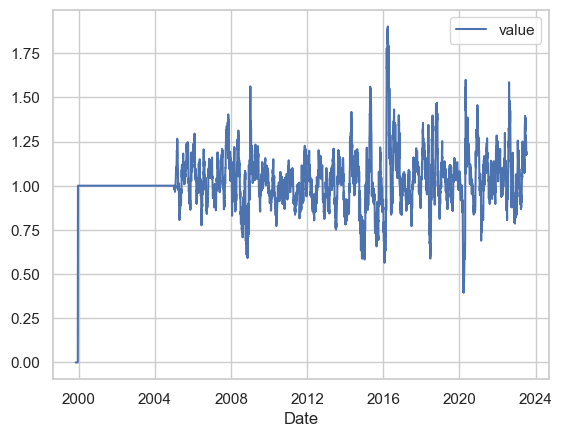

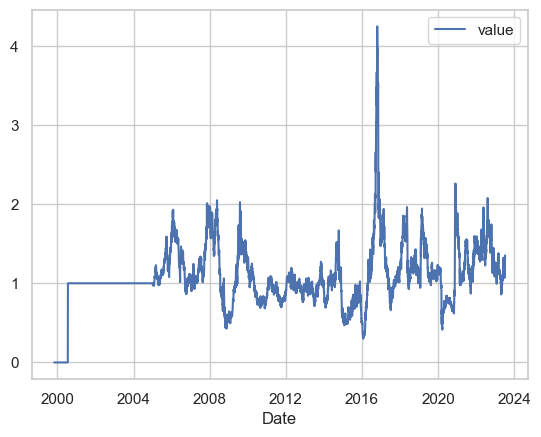

In [225]:
seaborn.lineplot(momentum_1T, color="r")
plt.show()
seaborn.lineplot(momentum_6T, color="b")
plt.show()

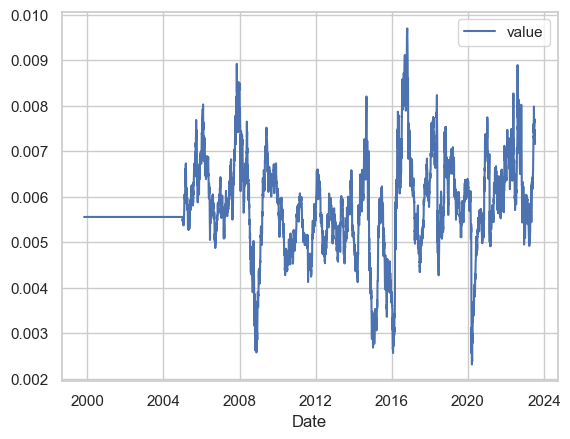

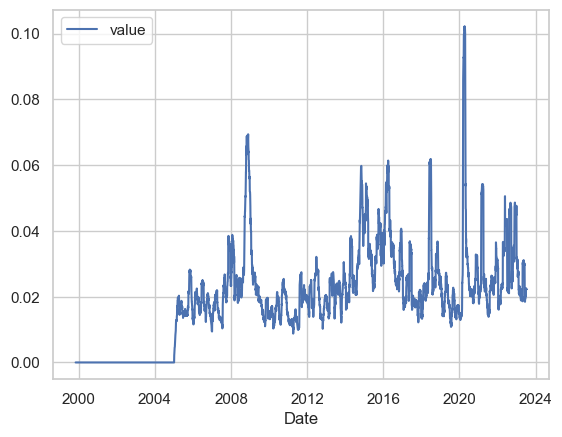

In [226]:
seaborn.lineplot(pcs_6T)
plt.show()
seaborn.lineplot(vol_1T)
plt.show()

In [227]:
def train_test_split(features, labels, percentage):
    size = int(len(features) * percentage)

    train = {"x": features[10:size], "y": labels[10:size].flatten()}
    test = {"x": features[size:], "y": labels[size:].flatten()}

    return train, test

def simulate_trade_allocation(title, y_pred, basis):
    y_pred_portfolio = numpy.array([1 - y_pred, y_pred]).T
    basis['BUY-PRED'] = numpy.argmin(y_pred_portfolio, axis=1)
    basis['SELL-PRED'] = numpy.argmax(y_pred_portfolio, axis=1)

    basis['BUY-PRED'] = basis['BUY-PRED'].shift(1).fillna(1)
    basis['SELL-PRED'] = basis['SELL-PRED'].shift(1).fillna(0)

    basis['PRED-PERCENTAGE'] = basis['PETR4.SA'].to_numpy().flatten() * basis['BUY-PRED'].to_numpy() + \
                           basis['AGRO3.SAO'].to_numpy().flatten() * basis['SELL-PRED'].to_numpy()
    changes_df['PRED-CHANGES'] = (1 + basis['PRED-PERCENTAGE'].fillna(0).to_numpy()).cumprod()

    print(title)
    seaborn.lineplot(100 * changes_df[['PRED-CHANGES', "PETR4.SA", "AGRO3.SAO"]])
    return changes_df["PRED-CHANGES"], \
        (changes_df["PRED-CHANGES"].iloc[-1] - changes_df["PRED-CHANGES"].iloc[0]) / changes_df["PRED-CHANGES"].iloc[0]  # final value - starting value  / starting value

## Alocação por classe para Momento (Usando RandomForest e MLP)

In [228]:
basis = changes_df[["PETR4.SA", "AGRO3.SAO"]].copy()
basis = basis.pct_change()
basis['1T'] = momentum_1T
basis['3T'] = momentum_3T
basis['6T'] = momentum_6T

basis["BUY"] = numpy.argmin(basis[["PETR4.SA", "AGRO3.SAO"]].to_numpy(), axis=1)

features = basis[["1T", "3T", "6T"]].to_numpy()
labels = basis[["BUY"]].to_numpy()

train, test = train_test_split(features, labels, 0.5)

RandomForest for 1, 3 and 6 months Momentum class
Date
1999-11-01    1.000000
1999-11-02    1.000000
1999-11-03    1.000000
1999-11-04    1.000000
1999-11-05    1.000000
                ...   
2023-07-06    5.246646
2023-07-07    5.220103
2023-07-10    5.228950
2023-07-11    5.158169
2023-07-12    5.069131
Name: PRED-CHANGES, Length: 6080, dtype: float64 
Returns: 4.069130571286874
Accuracy train: 0.999009900990099
Accuracy validation: 0.5398026315789474


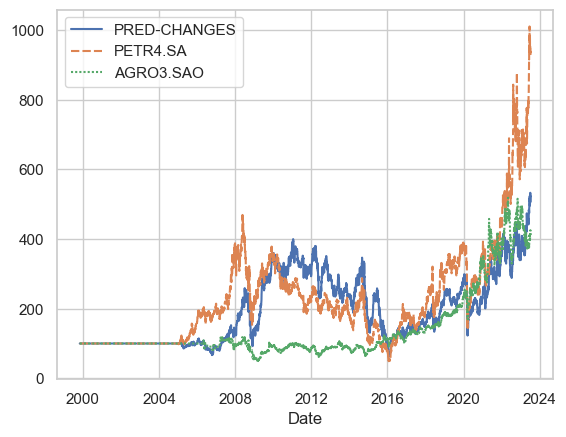

In [229]:
clf = RandomForestClassifier()
clf.fit(train["x"], train["y"])

y_pred_train = clf.predict(train["x"])
y_pred_val = clf.predict(test["x"])
y_pred = clf.predict(features)

pred_changes, returns = simulate_trade_allocation("RandomForest for 1, 3 and 6 months Momentum class", y_pred, basis)
print(pred_changes, f"\nReturns: {returns}")
print("Accuracy train:", accuracy_score(train["y"], y_pred_train))
print("Accuracy validation:", accuracy_score(test["y"], y_pred_val))

MLP (3 layered) for 1, 3 and 6 months Momentum class
Date
1999-11-01    1.000000
1999-11-02    1.000000
1999-11-03    1.000000
1999-11-04    1.000000
1999-11-05    1.000000
                ...   
2023-07-06    6.974326
2023-07-07    6.939043
2023-07-10    6.950804
2023-07-11    6.856715
2023-07-12    6.861420
Name: PRED-CHANGES, Length: 6080, dtype: float64 
Returns: 5.861419857341457
Accuracy train: 0.7184818481848185
Accuracy validation: 0.5348684210526315


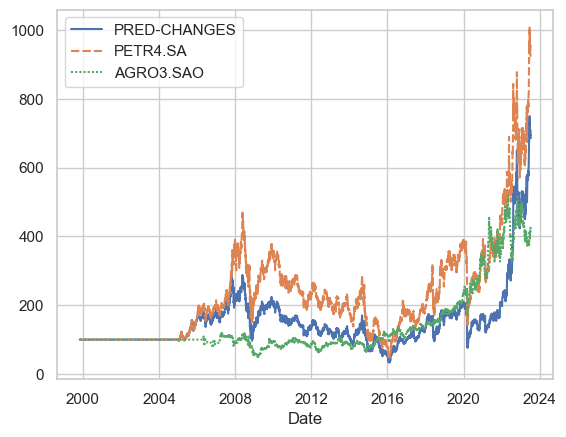

In [230]:
clf = MLPClassifier(hidden_layer_sizes=(3, ), max_iter=1000, activation='tanh')
clf.fit(train["x"], train["y"])

y_pred_train = clf.predict(train["x"])
y_pred_val = clf.predict(test["x"])
y_pred = clf.predict(features)

pred_changes, returns = simulate_trade_allocation("MLP (3 layered) for 1, 3 and 6 months Momentum class", y_pred, basis)
print(pred_changes, f"\nReturns: {returns}")
print("Accuracy train:", accuracy_score(train["y"], y_pred_train))
print("Accuracy validation:", accuracy_score(test["y"], y_pred_val))

## Alocação por Classe usando PCS (Price per Size) e Volatilidade

In [231]:
basis = changes_df[["PETR4.SA", "AGRO3.SAO"]].copy()
basis = basis.pct_change()
basis['PCS_1T'] = pcs_1T
basis['PCS_6T'] = pcs_6T
basis['VOL_1T'] = vol_1T
basis['VOL_6T'] = vol_6T

basis["BUY"] = numpy.argmin(basis[["PETR4.SA", "AGRO3.SAO"]].to_numpy(), axis=1)

features = basis[["PCS_1T", "PCS_6T", "VOL_1T", "VOL_6T"]].to_numpy()
labels = basis[["BUY"]].to_numpy()

train, test = train_test_split(features, labels, 0.5)

RandomForest for 1 and 6 months PCS + Vol classes
Date
1999-11-01     1.000000
1999-11-02     1.000000
1999-11-03     1.000000
1999-11-04     1.000000
1999-11-05     1.000000
                ...    
2023-07-06    10.152843
2023-07-07    10.259965
2023-07-10    10.180615
2023-07-11    10.113168
2023-07-12     9.938598
Name: PRED-CHANGES, Length: 6080, dtype: float64 
Returns: 8.938597615231103
Accuracy train: 0.9996699669966996
Accuracy validation: 0.5588815789473685


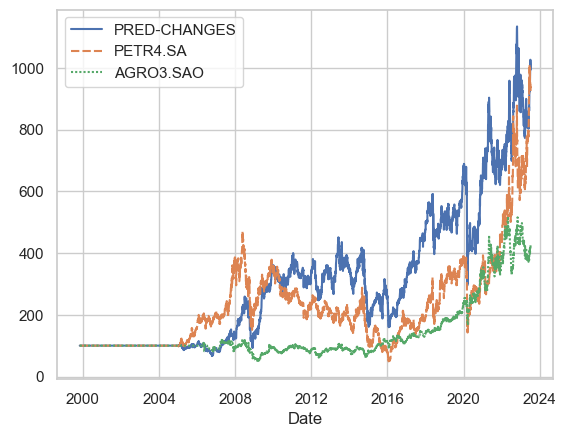

In [232]:
clf = RandomForestClassifier()
clf.fit(train["x"], train["y"])

y_pred_train = clf.predict(train["x"])
y_pred_val = clf.predict(test["x"])
y_pred = clf.predict(features)

pred_changes, returns = simulate_trade_allocation("RandomForest for 1 and 6 months PCS + Vol classes", y_pred, basis)
print(pred_changes, f"\nReturns: {returns}")
print("Accuracy train:", accuracy_score(train["y"], y_pred_train))
print("Accuracy validation:", accuracy_score(test["y"], y_pred_val))

MLP (6 layered) for 1 and 6 months PCS + Vol class
Date
1999-11-01    1.000000
1999-11-02    1.000000
1999-11-03    1.000000
1999-11-04    1.000000
1999-11-05    1.000000
                ...   
2023-07-06    8.095649
2023-07-07    8.181066
2023-07-10    8.117794
2023-07-11    8.064013
2023-07-12    7.924814
Name: PRED-CHANGES, Length: 6080, dtype: float64 
Returns: 6.9248144709385295
Accuracy train: 0.7125412541254126
Accuracy validation: 0.4930921052631579


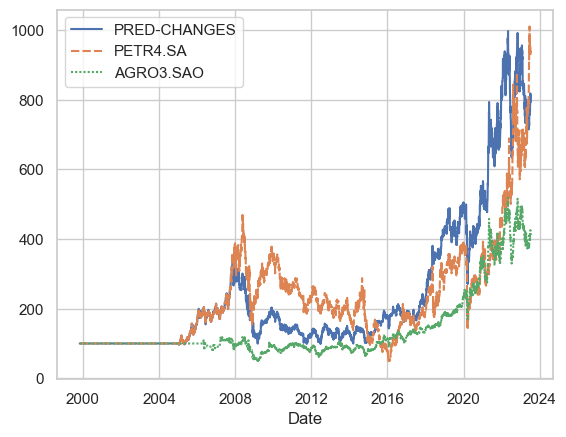

In [233]:
clf = MLPClassifier(hidden_layer_sizes=(20,), max_iter=2000, activation='tanh')
clf.fit(train["x"], train["y"])

y_pred_train = clf.predict(train["x"])
y_pred_val = clf.predict(test["x"])
y_pred = clf.predict(features)

pred_changes, returns = simulate_trade_allocation("MLP (6 layered) for 1 and 6 months PCS + Vol class", y_pred, basis)
print(pred_changes, f"\nReturns: {returns}")
print("Accuracy train:", accuracy_score(train["y"], y_pred_train))
print("Accuracy validation:", accuracy_score(test["y"], y_pred_val))

## Trading Sistemático

In [234]:
def get_series(symbol):
    if os.path.exists(f"{symbol}.csv"):
        try:
            security = pandas.read_csv(f"{symbol}.csv", index_col=0, parse_dates=True)
            security.index = pandas.to_datetime(security.index)
            return security
        except pandas.errors.EmptyDataError:
            pass
    if not symbol or symbol == "":
        raise ValueError("Invalid symbol: ", symbol)
    try:
        url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&outputsize=full&apikey=U93DVTNCTOO1DTTI"
        response = requests.get(url)

        data = pandas.DataFrame(response.json())
    except:
        raise ValueError("Invalid symbol: ", symbol)
    formatted_data = data[data.keys()[1]][5:]

    adjusted = pandas.DataFrame.from_records(formatted_data.values)[
        ["1. open", "2. high", "3. low", "4. close", "6. volume"]
    ]
    security = pandas.DataFrame(adjusted.values.astype(float), columns=["open", "high", "low", "close", "volume"],
                                index=formatted_data.index).sort_index()
    security.index.name = "Date"
    security.to_csv(f"{symbol}.csv")
    return get_adjusted(symbol)

              value
Date               
2005-01-03   3.1520
2005-01-04   3.1145
2005-01-05   3.1025
2005-01-06   3.1119
2005-01-07   3.1256
...             ...
2023-07-06  29.6500
2023-07-07  29.5000
2023-07-10  29.5500
2023-07-11  29.1500
2023-07-12  29.1700

[4583 rows x 1 columns]


<AxesSubplot:xlabel='Date', ylabel='close'>

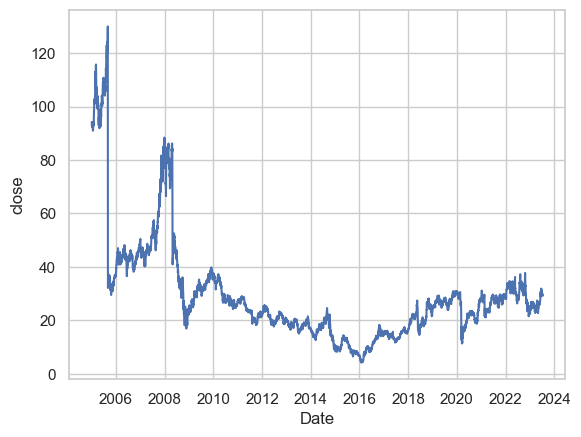

In [235]:
print(get_series("PETR4.SA"))
seaborn.lineplot(get_series("PETR4.SA")["close"])

In [236]:
def moving_average(series, T=1):
    return series.rolling(T * 30).mean().fillna(method='bfill')

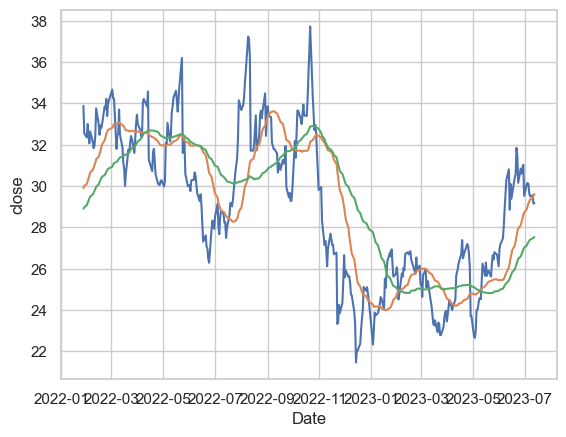

In [237]:
sample = get_series("PETR4.SA")
sample["fast"] = moving_average(sample["close"], 1)
sample["slow"] = moving_average(sample["close"], 2)

seaborn.lineplot(sample["close"][-365:])
seaborn.lineplot(sample["fast"][-365:])
seaborn.lineplot(sample["slow"][-365:])
plt.show()

In [238]:
def simulate_trade(data, method, starting_wallet=1):
    data['trades'] = starting_wallet
    buy = 0
    weight = 100

    buy_value, sell_value = 1, 1

    for idx, row in data.iterrows():
        r = method(idx, row, buy, buy_value, sell_value, weight)
        if r is None:
            continue
        buy, weight, buy_value, sell_value = r
        sample.at[idx, 'trades'] = weight


def trend_follow(idx, row, buy, buy_value, sell_value, weight):
    if row['fast'] > row['slow'] and buy == 0:
        buy = 1
        buy_value = row['close']
    elif row['fast'] < row['slow'] and  buy == 1:
        buy = 0
        weight = weight * (row['close'] / buy_value)
    elif row['fast'] < row['slow'] and buy == 0:
        buy = -1
        sell_value = row['close']
    elif row['fast'] > row['slow'] and buy == -1:
        buy = 0
        weight = weight * (sell_value / row['close'])

    return buy, weight, buy_value, sell_value

Profit for Trend Follow: 19.553809129511677 u.


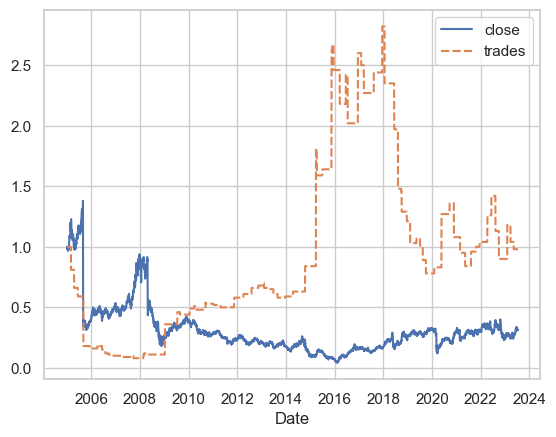

In [239]:
simulate_trade(sample, trend_follow)
change = sample[['close', 'trades']] / sample[['close', 'trades']].iloc[0]

print("Profit for Trend Follow: {} u.".format(
    (change["trades"].iloc[-1] - change["close"].iloc[-1]) * sample["close"].iloc[-1])
)
seaborn.lineplot(change)
plt.show()

<AxesSubplot:xlabel='Date'>

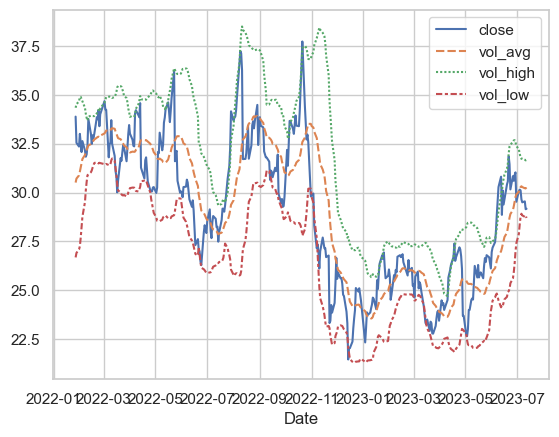

In [240]:
from ta.volatility import BollingerBands
ind_bb = BollingerBands(close=sample['close'], window=20, window_dev=2)

sample['vol_avg'] = ind_bb.bollinger_mavg()
sample['vol_high'] = ind_bb.bollinger_hband()
sample['vol_low'] = ind_bb.bollinger_lband()

seaborn.lineplot(sample[['close', 'vol_avg', 'vol_high', 'vol_low']].iloc[-365:])

In [241]:
def volatility_inversion(idx, row, buy, buy_value, sell_value, weight):
    if row['low'] < row['vol_low'] and buy == 0:
        buy = 1
        buy_value = row['close']
    elif row['close'] > row['vol_avg'] and  buy == 1:
        buy = 0
        weight = weight * (row['close'] / buy_value)
    elif row['high'] > row['vol_high'] and buy == 0:
        buy = -1
        sell_value = row['close']
    elif row['close'] < row['vol_avg'] and buy == -1:
        buy = 0
        weight = weight * (sell_value / row['close'])

    return buy, weight, buy_value, sell_value


Profit for Volatility Inversion: 25.096109129511678 u.


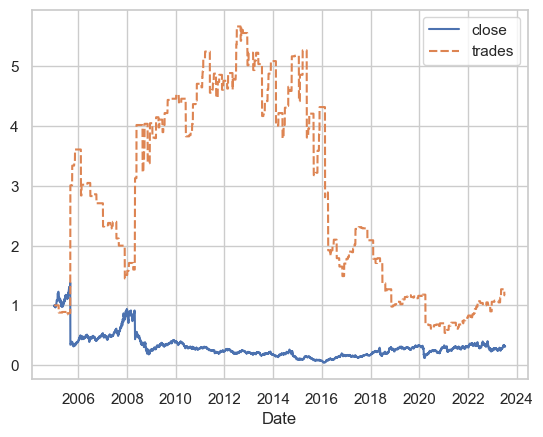

In [242]:
simulate_trade(sample, volatility_inversion)
change = sample[['close', 'trades']] / sample[['close', 'trades']].iloc[0]

print("Profit for Volatility Inversion: {} u.".format(
    (change["trades"].iloc[-1] - change["close"].iloc[-1]) * sample["close"].iloc[-1])
)
seaborn.lineplot(change)
plt.show()

In [243]:
from ta.momentum import RSIIndicator
indicator_rsi = RSIIndicator(close=sample['close'], window=2)
sample['RSI'] = indicator_rsi.rsi()

In [244]:
def rsii_low(idx, row, buy, buy_value, sell_value, weight):
    idx = sample.index.get_loc(idx)

    if idx < 2:
        return None

    if sample['RSI'].iat[idx] < 30 and buy == 0:
        buy = 1
        buy_value = sample['close'].iat[idx]
    elif sample['close'].iat[idx] > sample['high'].iat[idx - 1] and sample['close'].iat[idx] > sample['high'].iat[idx - 2] and buy == 1:
        buy = 0
        weight = weight * (sample['close'].iat[idx] / buy_value)
    return buy, weight, buy_value, sell_value

Profit for Buy low RSII: 11.969609129511678 u.


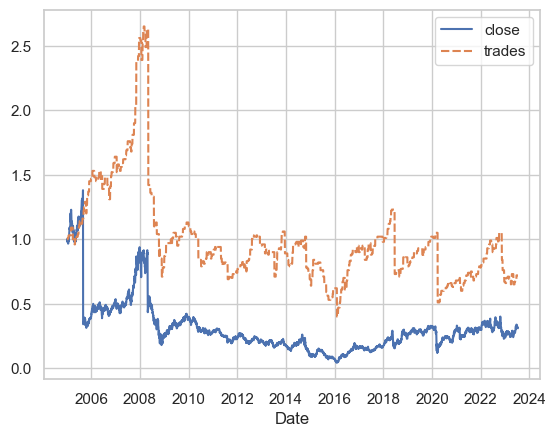

In [245]:
simulate_trade(sample, rsii_low, starting_wallet=100)
change = sample[['close', 'trades']] / sample[['close', 'trades']].iloc[0]

print("Profit for Buy low RSII: {} u.".format(
    (change["trades"].iloc[-1] - change["close"].iloc[-1]) * sample["close"].iloc[-1])
)
seaborn.lineplot(change)
plt.show()

c:\users\rafael.zimmer\workspace\tradingsystem\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='Date', ylabel='volume_price'>

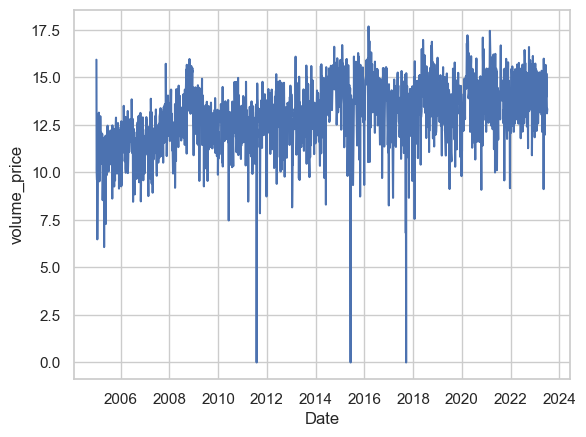

In [246]:
from ta.volume import VolumePriceTrendIndicator

volume_price = VolumePriceTrendIndicator(volume=sample["volume"], close=sample['close'], fillna=True)
sample['volume_price'] = numpy.log(volume_price.volume_price_trend().replace(0, 1).fillna('bfill'))

seaborn.lineplot(sample['volume_price'])

In [247]:
def volume_high(idx, row, buy, buy_value, sell_value, weight):
    if (row['volume'] / row['close']) < row['volume_price'] and buy == 0:
        buy = 1
        buy_value = row['close']
    elif (row['volume'] / row['close']) < row['volume_price'] and buy == 1:
        buy = 0
        weight = weight * (row['close'] / buy_value)
    elif (row['volume'] / row['close']) > row['volume_price'] and buy == 0:
        buy = -1
        sell_value = row['close']
    elif (row['volume'] / row['close']) > row['volume_price'] and buy == -1:
        buy = 0
        weight = weight * (sell_value / row['close'])

    return buy, weight, buy_value, sell_value

Date
2005-01-03    1.00
2005-01-04    1.01
2005-01-05    1.01
2005-01-06    1.01
2005-01-07    1.01
              ... 
2023-07-06    3.38
2023-07-07    3.38
2023-07-10    3.38
2023-07-11    3.38
2023-07-12    3.38
Name: trades, Length: 4583, dtype: float64
Profit for Volume Price: 89.56180912951169 u.


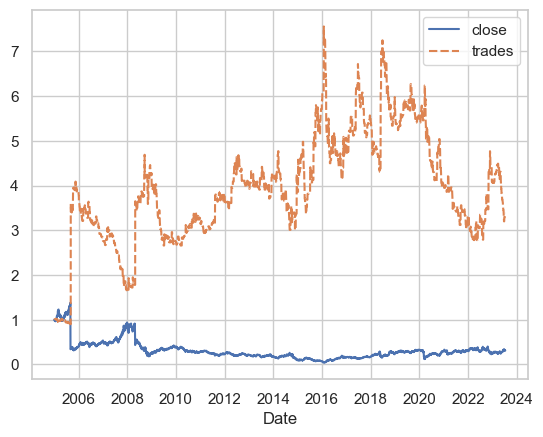

In [248]:
simulate_trade(sample, volume_high)
change = sample[['close', 'trades']] / sample[['close', 'trades']].iloc[0]
print(change["trades"])
print("Profit for Volume Price: {} u.".format(
    (change["trades"].iloc[-1] - change["close"].iloc[-1]) * sample["close"].iloc[-1])
)
seaborn.lineplot(change)
plt.show()